In [1]:
import sys
sys.path.append('..')

In [2]:
# Deep Learning
import torch
from torch import nn

# Data Utils
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

# Hand rolled utils
from util import data, metrics, preprocess
from models import spot, networks

# stats
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# io
import joblib

# notebook params
sns.set()
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.titlesize'] = 24
device = 'cuda' if torch.cuda.is_available() else 'cpu'

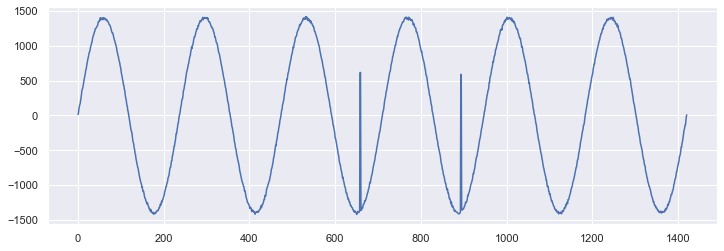

In [3]:
synth = pd.read_csv('synthetic_1.txt')
synth_tensor = torch.tensor(synth.value)
sns.lineplot(data=synth_tensor);

In [4]:
window = 7
n_features = 1
factor = 8
emb_size = window * n_features * factor

seqs = preprocess.sequence(synth_tensor, window)
transform = preprocess.Difference()
train_data = data.SimpleDataset(seqs, transform=transform)
train_loader = DataLoader(train_data, shuffle=True)

In [5]:
model = networks.LSTMEncoderDecoder(n_features, emb_size)
criterion = nn.MSELoss(reduction='sum')
lr = 3e-4
loss = networks.train_encoder(model, 
                             epochs=1000, 
                             lr=lr, 
                             criterion=criterion,
                             trainload=train_loader)

Training model on cpu


  0%|          | 0/1000 [00:00<?, ?it/s]

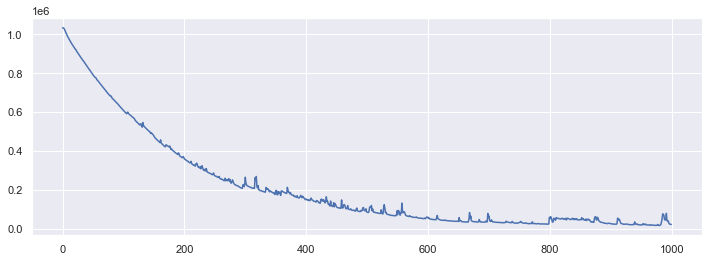

In [6]:
sns.lineplot(data=loss[0]);

In [7]:
torch.save(model.state_dict(), f'lstm_model_size={emb_size}_lr={lr}.pt')

In [8]:
# Get a random sample:
sample = seqs[60]

# apply difference transform
sample = transform(sample)

# add dimensions for batch size and # features
sample = sample.unsqueeze(0).unsqueeze(-1).float()

out = model(sample)
sample.squeeze().shape

torch.Size([7])

In [9]:
# invert difference transform
true = transform.inverse(sample.squeeze())
pred = transform.inverse(out.squeeze())

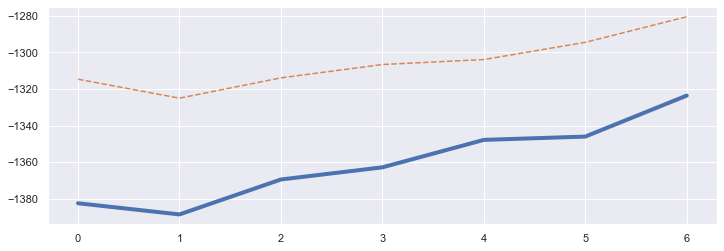

In [10]:
# plot original and reconstruction
plt.plot(true.detach().numpy(), '-', linewidth=4, label='Input')
plt.plot(pred.detach().numpy(), '--', label='Reconstructed');

In [11]:
# Run inference on all data.
reconstructed = torch.tensor([])
for seq in train_data:
    x = seq.unsqueeze(0).unsqueeze(-1).float()
    with torch.no_grad():
        x_hat = model(x)
        reconstructed = torch.cat((reconstructed, x_hat))
    

In [12]:
reconstructed = reconstructed.squeeze()

# Invert difference transform
reconstructed = [transform.inverse(seq) for seq in reconstructed]

# Concatenate sub-sequences
reconstructed = torch.cat(tuple(reconstructed))

In [13]:
# Get L1 Loss of whole data set.
criterion = nn.L1Loss(reduction='none')
loss = criterion(reconstructed, synth_tensor);

In [14]:
# get zscores 
scores = stats.zscore(loss)

# Build cumulative density function of scores
cdf = ECDF(scores.squeeze())

# Get threshold
thresh = next(x for x in scores if cdf(x) > 0.99)

# get x, y coordinates for plotting anoms.
x = np.where(scores > thresh)[0]
y = scores[scores > thresh]

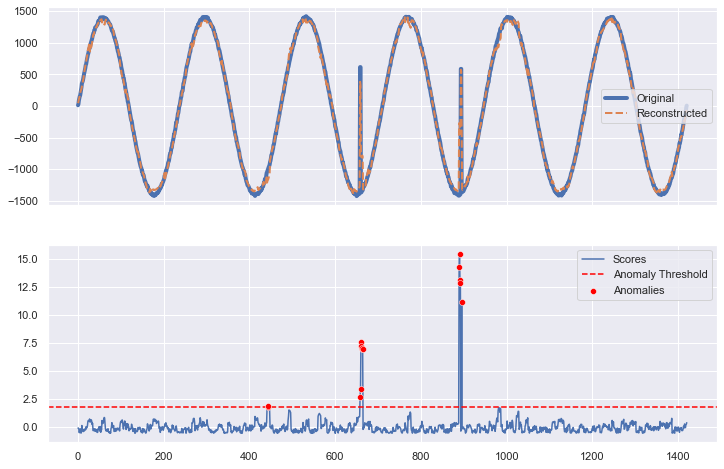

In [20]:
fig, ax, = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Reconstruction
sns.lineplot(data=synth_tensor, linestyle='-', linewidth=4, ax=ax[0], label="Original")
sns.lineplot(data=reconstructed, linestyle='--', linewidth=2, ax=ax[0], label='Reconstructed')

# Anomaly detection
sns.lineplot(data=scores, label='Scores', ax=ax[1])
sns.scatterplot(x=x, y=y, color='red', ax=ax[1], label='Anomalies', zorder=3)
ax[1].axhline(y=thresh, c='red', linestyle='--', label='Anomaly Threshold')

plt.legend(loc='upper right')
plt.show()